<a href="https://colab.research.google.com/github/zliu892/ECE-539-Group6/blob/main/7AgeGroup_Data_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Age & Gender Classifier using Deep CNNs  - 

**Dataset : UTKFace**

### Libraries Importing

In [ ]:
# Essential libraries
import numpy as np 
import pandas as pd
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io
from keras import applications,activations
from keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
from keras import optimizers,utils
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D,BatchNormalization,ZeroPadding2D, Input
from keras.layers import Conv2D, Activation,MaxPooling2D
from keras import backend as k 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

### Drive Mounting

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Dataset Loading

In [ ]:
dataset_folder_name = '/content/drive/My Drive/ECE_539_Project/UTKFace'
TRAIN_TEST_SPLIT = 0.8
IM_WIDTH = IM_HEIGHT = 98

dataset_dict = {
    'race_id': {
        0: 'white', 
        1: 'black', 
        2: 'asian', 
        3: 'indian', 
        4: 'others'
    },
    'gender_id': {
        0: 'male',
        1: 'female'
    }
}

dataset_dict['gender_alias'] = dict((g, i) for i, g in dataset_dict['gender_id'].items())    # (Gender: id)
dataset_dict['race_alias'] = dict((r, i) for i, r in dataset_dict['race_id'].items())        # (Race: id)

The function below will be used to iterate over each file of the UTK dataset and return a Pandas Dataframe containing all the fields (age, gender and sex) of our records.

In [ ]:
def parse_dataset(dataset_path, ext='jpg'):
    """
    Used to extract information about our dataset. It does iterate over all images and return a DataFrame
     with the data (age, gender and sex) of all files.
    """
    def parse_info_from_file(path):
        """
        Parse information from a single file
        """
        try:
            filename = os.path.split(path)[1]
            filename = os.path.splitext(filename)[0]
            age, gender, race, _ = filename.split('_')

            return int(age), dataset_dict['gender_id'][int(gender)], dataset_dict['race_id'][int(race)]
        except Exception as ex:
            return None, None, None
        
    files = glob.glob(os.path.join(dataset_path, "*.%s" % ext))
    
    records = []
    for file in files:
        info = parse_info_from_file(file)
        records.append(info)
        
    df = pd.DataFrame(records)
    df['file'] = files
    df.columns = ['age', 'gender', 'race', 'file']
    
   
    df = df.dropna()
    
    return df

In [ ]:
df = parse_dataset(dataset_folder_name)
df.head()

,age,gender,race,file
0,56.0,male,indian,/content/drive/My Drive/ECE_539_Project/UTKFac...
1,56.0,male,indian,/content/drive/My Drive/ECE_539_Project/UTKFac...
2,56.0,male,indian,/content/drive/My Drive/ECE_539_Project/UTKFac...
3,56.0,male,asian,/content/drive/My Drive/ECE_539_Project/UTKFac...
4,56.0,male,indian,/content/drive/My Drive/ECE_539_Project/UTKFac...


In [ ]:
import plotly.graph_objects as go
def plot_distribution(pd_series):
    labels = pd_series.value_counts().index.tolist()
    counts = pd_series.value_counts().values.tolist()
    
    pie_plot = go.Pie(labels=labels, values=counts, hole=.3)
    fig = go.Figure(data=[pie_plot])
    fig.update_layout(title_text='Distribution for %s' % pd_series.name)
    
    fig.show()

### Data Analysis & Visualization (EDA)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23705 entries, 0 to 23707
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     23705 non-null  float64
 1   gender  23705 non-null  object 
 2   race    23705 non-null  object 
 3   file    23705 non-null  object 
dtypes: float64(1), object(3)
memory usage: 926.0+ KB


In [ ]:
df.describe()

,age
count,23705.000000
mean,33.300907
std,19.885708
min,1.000000
25%,23.000000
50%,29.000000
75%,45.000000
max,116.000000


In [ ]:
bins = [0, 10, 20, 30, 40, 60, 80, np.inf]
names = ['<10', '10-20', '20-30', '30-40', '40-60', '60-80', '80+']
age_binned = pd.cut(df['age'], bins, labels=names)
plot_distribution(age_binned)

In [ ]:
x = (df.gender=='male').sum()
y = (df.gender=='female').sum()
gender = [x,y]
plot_distribution(df['gender'])

In [ ]:
df.groupby(['gender']).mean()    

,age
gender,
female,30.678186
male,35.695666


In [ ]:
x = (df.race=='white').sum()
y = (df.race=='black').sum()
z = (df.race=='asian').sum()
a = (df.race=='indian').sum()
b = (df.race=='others').sum()

plot_distribution(df['race'])

In [ ]:
df.groupby(['race']).mean() 

,age
race,
asian,25.867501
black,33.860362
indian,31.532830
others,23.169031
white,37.980949


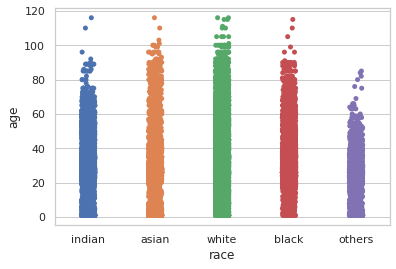

In [ ]:
sns.set(style ="whitegrid") 
_ = sns.stripplot(x='race',y='age',data=df)

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning:

The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y, hue. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



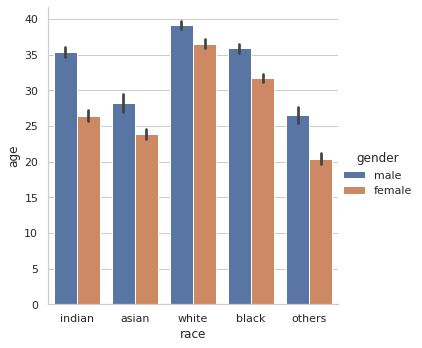

In [ ]:
sns.factorplot('race', 'age', 'gender', data=df,kind='bar');
# Gives the mean age of both genders of all races

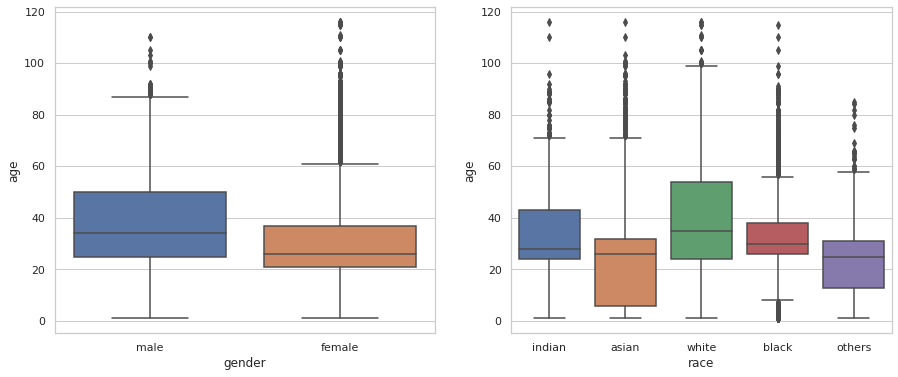

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
_ = sns.boxplot(data=df, x='gender', y='age', ax=ax1)
_ = sns.boxplot(data=df, x='race', y='age', ax=ax2)
# We see that most of males are between 25 and 55, whereas most of the females are between 20 and 35
# Even while grouping by race, we find good amount of variations in different races

In [ ]:
bins = [0, 10, 20, 25, 30, 40, 60, np.inf]
names = [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0]
df['age_group'] = pd.cut(df['age'], bins, labels=names)

''' This basically makes 7 divisions in age-groups - 
1. 0-9
2. 10-19
3. 20-24
4. 25-29
5. 30-39 
6. 40-59
7. 60+  '''
print(df['age_group'])

0        5.0
1        5.0
2        5.0
3        5.0
4        5.0
        ... 
23703    0.0
23704    0.0
23705    0.0
23706    0.0
23707    0.0
Name: age_group, Length: 23705, dtype: category
Categories (7, float64): [0.0 < 1.0 < 2.0 < 3.0 < 4.0 < 5.0 < 6.0]


/usr/local/lib/python3.7/dist-packages/pandas/io/formats/format.py:1429: FutureWarning:

Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.



In [ ]:
x = (df.age_group==0.0).sum()
y = (df.age_group==1.0).sum()
z = (df.age_group==2.0).sum()
a = (df.age_group==3.0).sum()
b = (df.age_group==4.0).sum()
c = (df.age_group==5.0).sum()
d = (df.age_group==6.0).sum()
 

print(x,' ',y,' ',z,' ',a,' ',b, ' ',c,' ',d)


3218   1659   2760   5024   4338   4311   2395


In [ ]:
names = ['<10', '10-20', '20-25', '25-30', '30-40', '40-60', '60+']
age_binned = pd.cut(df['age'], bins, labels=names)
plot_distribution(age_binned)

In [ ]:
df.head()

,age,gender,race,file,age_group
0,56.0,male,indian,/content/drive/My Drive/ECE_539_Project/UTKFac...,5.0
1,56.0,male,indian,/content/drive/My Drive/ECE_539_Project/UTKFac...,5.0
2,56.0,male,indian,/content/drive/My Drive/ECE_539_Project/UTKFac...,5.0
3,56.0,male,asian,/content/drive/My Drive/ECE_539_Project/UTKFac...,5.0
4,56.0,male,indian,/content/drive/My Drive/ECE_539_Project/UTKFac...,5.0


## Data Generator

We will get train_idx, valid_idx, test_idx

In [ ]:
from tensorflow.keras.utils import to_categorical
from PIL import Image
p = np.random.permutation(len(df))

train_up_to = int(len(df) * TRAIN_TEST_SPLIT)      
train_idx = p[:train_up_to]
val_idx = p[train_up_to:]

Convert alias to id

In [ ]:
df['gender_id'] = df['gender'].map(lambda gender: dataset_dict['gender_alias'][gender])
df['race_id'] = df['race'].map(lambda race: dataset_dict['race_alias'][race])

Perform some minor preprocessing on the image before inputting into the network.

In [ ]:
def preprocess_image(img_path):
    
    im = Image.open(img_path)
    im = im.resize((IM_WIDTH, IM_HEIGHT))
    im = np.array(im) / 255.0
    
    return im

Generate a batch with images when training/validating our model.

In [ ]:
def generate_images(image_idx, is_training, batch_size=16):  
    images, ages, races, genders = [], [], [], []

    while True:
        for idx in image_idx:
            person = df.iloc[idx]
            
            age = person['age_group']
            race = person['race_id']
            gender = person['gender_id']
            file = person['file']
            
            im = preprocess_image(file)
            
            races.append(to_categorical(race, len(dataset_dict['race_id'])))
            genders.append(to_categorical(gender, len(dataset_dict['gender_id'])))
            ages.append(to_categorical(age,7))
            images.append(im)
            
            # yielding condition
            if len(images) >= batch_size:
                yield np.array(images), [np.array(ages), np.array(genders)]
                images, ages, genders = [], [], []
                
        if not is_training:
            break

## Model Architecture

In [ ]:
from keras.models import Model
from tensorflow.keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import SeparableConv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers import SpatialDropout2D
from keras.layers.core import Lambda
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.regularizers import l2

import tensorflow as tf

def make_default_hidden_layers(inputs):

    # x = SeparableConv2D(32, (1, 1), padding="same")(inputs)
    x = SeparableConv2D(32, (3, 3), padding="same")(inputs)
    x = BatchNormalization(axis=-1)(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(3, 3))(x)

    # x = SeparableConv2D(64, (1, 1), padding="same")(x)
    x = SeparableConv2D(64, (3, 3), padding="same")(x)
    x = BatchNormalization(axis=-1)(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    # x = SeparableConv2D(128, (1, 1), padding="same")(x)
    x = SeparableConv2D(128, (3, 3), padding="same")(x)
    x = BatchNormalization(axis=-1)(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    # x = SeparableConv2D(128, (1, 1), padding="same")(x)
    x = SeparableConv2D(128, (3, 3), padding="same")(x)
    x = BatchNormalization(axis=-1)(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = SpatialDropout2D(0.1)(x)

    # x = SeparableConv2D(256, (1, 1), padding="same")(x)
    x = SeparableConv2D(256, (3, 3), padding="same")(x)
    x = BatchNormalization(axis=-1)(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = SpatialDropout2D(0.1)(x)
    

    # x = SeparableConv2D(256, (1, 1), padding="same")(x)
    x = SeparableConv2D(256, (3, 3), padding="same")(x)
    x = BatchNormalization(axis=-1)(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = SpatialDropout2D(0.15)(x)
    

    # x = SeparableConv2D(256, (1, 1), padding="same")(x)
    x = SeparableConv2D(256, (3, 3), padding="same")(x)
    x = BatchNormalization(axis=-1)(x)
    x = Activation("relu")(x)
    # x = MaxPooling2D(pool_size=(2, 2))(x)
    x = MaxPooling2D(pool_size=(1, 1))(x)
    x = SpatialDropout2D(0.15)(x)
    

    return x

def build_gender_branch(inputs):
  
    x = make_default_hidden_layers(inputs)

    x = Flatten()(x)
    x = Dense(64)(x)
    x = Activation("relu")(x)
    x = Dropout(0.3)(x)
    x = BatchNormalization()(x)

    x = Dense(32)(x)
    x = Activation("relu")(x)
    x = Dropout(0.25)(x)
    x = BatchNormalization()(x)
  
    x = Dense(2)(x)
    x = Activation("softmax", name="gender_output")(x)

    return x

def build_age_branch(inputs):   

    x = make_default_hidden_layers(inputs)
    
    x = Flatten()(x)
    x = Dense(128, kernel_regularizer=l2(0.03))(x)
    x = Activation("relu")(x)
    x = Dropout(0.3)(x)
    x = BatchNormalization()(x)

    x = Dense(64)(x)
    x = Activation("relu")(x)
    x = Dropout(0.3)(x)
    x = BatchNormalization()(x)
    
    x = Dense(32)(x)
    x = Activation("relu")(x)
    x = Dropout(0.2)(x)
    x = BatchNormalization()(x)

    x = Dense(7)(x)
    x = Activation("softmax", name="age_output")(x)  

    return x


def assemble_model(width, height):
  
    input_shape = (height, width, 3)
    inputs = Input(shape=input_shape)

    age_branch = build_age_branch(inputs)
    gender_branch = build_gender_branch(inputs)

    model = Model(inputs=inputs, outputs = [age_branch, gender_branch], name="face_net")

    return model
    
model = assemble_model(98, 98)

## Train the model

In [ ]:
# A callback is a set of functions to be applied at given stages of the training procedure.

import math
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.callbacks import LearningRateScheduler

#  When training a neural network, the learning rate is often the most important 
# hyperparameter to tune. When training deep neural networks, it is often useful 
# to reduce learning rate as the training progresses.

# LRS in Keras reduces the learning rate by a certain factor after certain no of epochs

def step_decay(epoch):
	initial_lrate = 0.008
	drop = 0.5
	epochs_drop = 5.0
	lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lrate      

opt = Adam(lr=0.0)                                     # 0.0 here signifies this is not to be used
lrate = LearningRateScheduler(step_decay)

model.compile(optimizer=opt, 
              loss={
                  'age_output': 'categorical_crossentropy', 
                  'gender_output': 'categorical_crossentropy'},
              metrics={
                  'age_output': 'accuracy', 
                  'gender_output': 'accuracy'})

callbacks_list = [lrate]

# It is this callback that allows a function to invoke during program execution.

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



In [ ]:
train_gen = generate_images(train_idx, is_training=True, batch_size=32)

# Since, train_idx is too large to fit inside RAM at once, we generate batches of size 32/64 from it (called train_gen))

valid_gen = generate_images(val_idx, is_training=True, batch_size=32)


history = model.fit(train_gen, steps_per_epoch = len(train_idx)//32, epochs=22  , callbacks=callbacks_list,
                     validation_data=valid_gen, validation_steps=len(val_idx)//32)

Epoch 1/22
463/592 [======================>.......] - ETA: 30:22 - loss: 2.7700 - age_output_loss: 1.7266 - gender_output_loss: 0.5338 - age_output_accuracy: 0.3045 - gender_output_accuracy: 0.7295

### Save the trained model

In [ ]:
model.save("/content/drive/My Drive/ECE_539_Project/classifier_model2.h5")  # Converting to .h5 file for deployment

NameError: ignored

### Plot the age group and gender estimation accuracy

In [ ]:
import plotly.graph_objects as go
plt.clf()
fig = go.Figure()
fig.add_trace(go.Scatter(
                    y=history.history['gender_output_accuracy'],
                    name='Train'))
fig.add_trace(go.Scatter(
                    y=history.history['val_gender_output_accuracy'],
                    name='Valid'))
fig.update_layout(height=500, 
                  width=700,
                  title='Accuracy for gender feature',
                  xaxis_title='Epoch',
                  yaxis_title='Accuracy')
fig.show()

In [ ]:
plt.clf()
fig = go.Figure()
fig.add_trace(go.Scattergl(
                    y=history.history['age_output_accuracy'],
                    name='Train'))
fig.add_trace(go.Scattergl(
                    y=history.history['val_age_output_acc'],
                    name='Valid'))
fig.update_layout(height=500, 
                  width=700,
                  title='Accuracy for age feature',
                  xaxis_title='Epoch',
                  yaxis_title='Accuracy')
fig.show()

## Results

### Load the model

In [ ]:
from keras.models import load_model
clf_model = load_model('/content/drive/My Drive/ECE_539_Project/classifier_model2.h5')